# Asian option pricing


## Imports & utilities


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [7, 5]
IMG_DPI = 100

In [73]:
GREEN = "#5be560" 
RED = "#cc4422"
BLUE = "#6a66d1"

DARK_GREEN = "#408443" 
DARK_RED = "#8e3e2a"
DARK_BLUE = "#282582"

FILL_RED = "#e09582"
FILL_GREEN = "#b0e8b2c6"

## Black-Scholes related utilities

In [74]:
def norm_cdf(x):
    """ Approximation of the normal distribution function with an error less than 7.5*10^-8 """
    assert x >= 0 or x < 0
    coefficients = [0.2316419, 0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.33027442]
    if x >= 0:
        t = 1 / (1 + coefficients[0] * x)
        terms = [coefficients[i] * t**i for i in range(1, 6)]
        approx = 1 - (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2) * sum(terms)
        return approx
    else:
        return 1 - norm_cdf(-x)

In [75]:
def call_eur_bs(r, sig, T, S0, K):
    """ Price of a call option under the B&S model """
    d1 = (np.log(S0 / K) + (r + 0.5 * sig**2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    return (
        S0 * norm_cdf(d1)
        - K * np.exp(-r * T) * norm_cdf(d2)
    )

In [76]:
def price_paths_bs(r, sig, T, S0, num_subdivs, num_paths):
    """ Computes num_paths price paths under the B&S model, having num_sibdivs subdivisions """
    step = (T/num_subdivs)
    log_diffs = (r-0.5*sig**2) * step + sig*np.sqrt(step)*npr.normal(0, 1, size=(num_paths, num_subdivs))
    log_diffs = np.concatenate((np.log(S0)*np.ones((num_paths, 1)), log_diffs), axis=1)
    log_paths = np.cumsum(log_diffs, axis=1)
    price_paths = np.exp(log_paths)

    return price_paths

## Turnbull & Wakeman approximation

Turnbull & Wakeman have provided an approximation of the price of an asian option, as a european option with different parameters.

In [77]:
def tnw_coeffs_con(r, sig, T):
    """ Calculates the r_a and sigma_a coefficients from the Turnbull & Wakeman approximation for an asian option """
    M1 = (np.exp(r*T)-1)/(r*T)
    M2 = ( 
        (2*np.exp((2*r+sig**2)*T)) / ((r+sig**2) * (2*r+sig**2) * T**2)
        + (2/(r*T**2)) * (1/(2*r+sig**2) - np.exp(r*T) / (r+sig**2))
    )

    r_a = np.log(M1) / T 
    sig_a = np.sqrt(-2*r_a + np.log(M2)/T)
    return (r_a, sig_a)

In [78]:
def tnw_coeffs_dis(r, sig, T, num_subdivs):
    """ Calculates the r_a and sigma_a coefficients from the Turnbull & Wakeman approximation for an asian option """
    dt = T/num_subdivs
    N = num_subdivs
    t0 = np.exp((2*r+sig**2)*dt)
    t1 = np.exp(r*dt)
    M1 = (1 / N)*( (t1*(1-np.exp(r*T))) / (1-t1) )
    M2 = (
        (1/(N**2))*( (t0 * (1-np.exp((2*r+sig**2)*T)) ) / (1-t0) )
        + (1/(N**2))*(2*t1/(1-t1))*( 
        t0 * ( (1-np.exp((2*r+sig**2)*(N-1)*dt)) / (1-t0) )
        - np.exp(((N+1)*r+sig**2)*dt) * ( (1-np.exp((r+sig**2)*(N-1)*dt)) / (1-np.exp((r+sig**2)*dt)) )
    ))

    r_A = np.log(M1) / T
    sig_a = np.sqrt(np.log(M2)/T - 2 * r_A)

    return (r_A, sig_a)

In [79]:
def call_asian_bs_tnw_con(r, sig, T, S0, K):
    """ Calculates price of an asian option under the Turnbull & Wakeman approximation and the Black-Scholes model """
    r_a, sig_a = tnw_coeffs_con(r, sig, T)
    return call_eur_bs(r_a, sig_a, T, S0, K)

In [80]:
def call_asian_bs_tnw_dis(r, sig, T, S0, K, num_subdivs):
    """ Calculates price of an asian option under the Turnbull & Wakeman approximation and the Black-Scholes model """
    r_a, sig_a = tnw_coeffs_dis(r, sig, T, num_subdivs)
    return call_eur_bs(r_a, sig_a, T, S0, K)

## Monte-Carlo approximation

In [81]:
def call_asian_bs_mc(r, sig, T, S0, K, num_subdivs, num_paths):
    """ Computes the price of an Asian option call using a Monte-Carlo technique """
    price_paths = price_paths_bs(r, sig, T, S0, num_subdivs, num_paths)

    payoffs_asian = np.exp(-r*T)*np.maximum(price_paths.mean(axis=1) - K, 0)
    var = payoffs_asian.var(ddof=1) / num_paths

    return payoffs_asian.mean(), var

In [82]:
def ctrl_coeffs(r, sig, n):
    """ Coefficients used by the control variable """
    sig_e = (sig/n)*np.sqrt( ((n+1)*(2*n+1)) / 6 )
    r_e = 0.5*sig_e**2 + (r-0.5*sig**2)*(n+1)/(2*n)

    return (r_e, sig_e)

In [83]:
def call_asian_bs_mc_ctrl(r, sig, T, S0, K, num_subdivs, num_paths):
    """ Calculate a monte-carlo simulation of the asian price with a lower variance """

    price_paths = price_paths_bs(r, sig, T, S0, num_subdivs, num_paths)
    payoffs_asian = np.maximum(price_paths.mean(axis=1) - K, 0)
    control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)

    r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
    control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
    res_sample = np.exp(-r*T)*(payoffs_asian - control_samples) + control_mean

    var = res_sample.var(ddof=1) / num_paths
    return (res_sample.mean(), var)
    

## Tests

In [84]:
S0 = 1               # Spot
K = 1                # Strike
sig = 0.3            # Vol.
T = 6                # Expiration
r = 0.01             # Risk-free rate
num_paths = 7000     # Number of simulations (monte-carlo)
num_subdivs = 252*6  # Number of steps for brownian motion

In [85]:
tnw_approx = call_asian_bs_tnw_dis(r, sig, T, S0, K, num_subdivs)
mc_approx, var = call_asian_bs_mc(r, sig, T, S0, K, num_subdivs, num_paths)
mc_approx_c, var_c = call_asian_bs_mc_ctrl(r, sig, T, S0, K, num_subdivs, num_paths)

print(f"Approximation Monte-Carlo  : {mc_approx:.3f}€ (var={var:.6f})")
print(f"Variable de contrôle       : {mc_approx_c:.3f}€ (var={var_c:.6f})")
print(f"Approximation T&W discrète : {tnw_approx:.3f}€")

Approximation Monte-Carlo  : 0.173€ (var=0.000016)
Variable de contrôle       : 0.187€ (var=0.000001)
Approximation T&W discrète : 0.186€


## Ploting

### Ploting against monte-carlo steps


In [87]:
def var_evolution(arr):
	""" Given multiple samples, calculate the evolution of the variance of the samples """
	output_arr = np.zeros(len(arr)-2)
	for i in range(len(output_arr)):
		output_arr[i] = arr[:i+2].var(ddof=1) / (i+1)
	return output_arr

In [88]:
# Calculation of the paths
price_paths = price_paths_bs(r, sig, T, S0, num_subdivs, num_paths)

# Control variable monte-carlo
r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
asian_mc_samples = np.maximum(price_paths.mean(axis=1) - K, 0)
control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)
asian_ctrl_mc_samples = np.exp(-r*T)*(asian_mc_samples - control_samples) + control_mean
asian_mc_samples *= np.exp(-r*T)

# TWN approx
tnw_approx = call_asian_bs_tnw_dis(r, sig, T, S0, K, num_subdivs)

# Evolution of the Monte-Carlo simulation
mean_vec = np.array([(1/i) for i in range(1, len(asian_mc_samples)+1)])
asian_mc_evol = asian_mc_samples.cumsum() * mean_vec
asian_mc_ctrl_evol = asian_ctrl_mc_samples.cumsum() * mean_vec

# Calculation of the variance
critical_value = 1.645
asian_mc_std = np.sqrt(var_evolution(asian_mc_samples))
asian_mc_lower_bound = asian_mc_evol[2:] - critical_value*asian_mc_std
asian_mc_upper_bound = asian_mc_evol[2:] + critical_value*asian_mc_std

asian_mc_ctrl_std = np.sqrt(var_evolution(asian_ctrl_mc_samples))
asian_mc_ctrl_lower_bound = asian_mc_ctrl_evol[2:] - critical_value*asian_mc_ctrl_std
asian_mc_ctrl_upper_bound = asian_mc_ctrl_evol[2:] + critical_value*asian_mc_ctrl_std

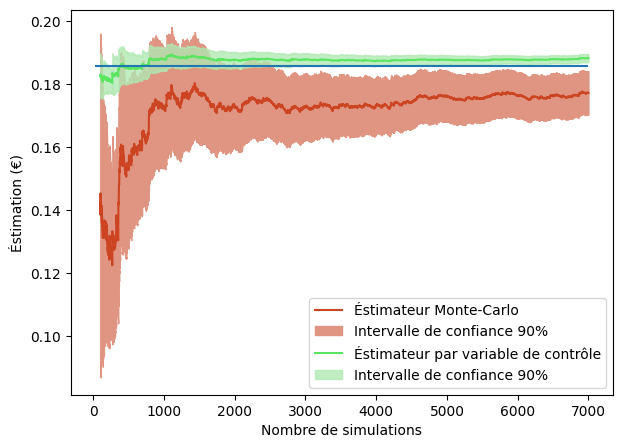

In [89]:
start_index = 100 # Starting plot index
x = np.arange(start=start_index, stop=len(asian_mc_ctrl_evol), step=1)

plt.plot(x, asian_mc_evol[start_index:], c=RED, label="Éstimateur Monte-Carlo")
plt.fill_between(x, asian_mc_lower_bound[start_index-2:], asian_mc_upper_bound[start_index-2:], color=FILL_RED, label="Intervalle de confiance 90%")

plt.plot(x, asian_mc_ctrl_evol[start_index:], c=GREEN, label="Éstimateur par variable de contrôle")
plt.fill_between(x, asian_mc_ctrl_lower_bound[start_index-2:], asian_mc_ctrl_upper_bound[start_index-2:], color=FILL_GREEN, label="Intervalle de confiance 90%")

plt.hlines(tnw_approx, xmin=30, xmax=num_paths)
plt.xlabel("Nombre de simulations")
plt.ylabel("Éstimation (€)")
plt.legend()
plt.savefig("figures/monte_carlo_conv.png", dpi=IMG_DPI)
plt.show()

### Ploting against K

In [90]:
def approx_calc_K(K, price_paths):
    """ Utility function that calculate a M-C simulation with given price paths """
    # Control variable monte-carlo
    r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
    control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
    asian_mc_samples = np.maximum(price_paths.mean(axis=1) - K, 0)
    control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)
    asian_ctrl_mc_samples = np.exp(-r*T)*(asian_mc_samples - control_samples) + control_mean

    approx = asian_ctrl_mc_samples.mean()
    std_dev = asian_ctrl_mc_samples.std(ddof=1) / np.sqrt(len(asian_ctrl_mc_samples))
    return approx, std_dev

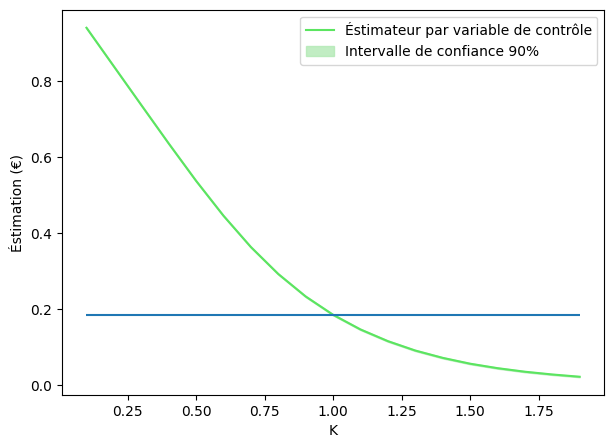

In [91]:
num_paths = 3000 # To be calculated with a real criterion
critical_value = 1.645

price_paths = price_paths_bs(r, sig, T, S0, num_subdivs, num_paths)
K_range = np.arange(0.1, 2.0, 0.1)
approx_vec = np.zeros(K_range.shape)
std_vec = np.zeros(K_range.shape)
for i in range(len(K_range)):
	approx, std_dev = approx_calc_K(K_range[i], price_paths)
	approx_vec[i] = approx
	std_vec[i] = std_dev

tnw_approx = call_asian_bs_tnw_dis(r, sig, T, S0, K, num_subdivs)
lower = approx_vec - critical_value * std_vec
upper = approx_vec + critical_value * std_vec
plt.plot(K_range, approx_vec, c=GREEN, label="Éstimateur par variable de contrôle")
plt.fill_between(K_range, lower, upper, color=FILL_GREEN, label="Intervalle de confiance 90%")

plt.hlines(tnw_approx, xmin=K_range.min(), xmax=K_range.max())
plt.xlabel("K")
plt.ylabel("Éstimation (€)")
plt.legend()
plt.savefig("figures/value_vs_K.png", dpi=IMG_DPI)
plt.show()

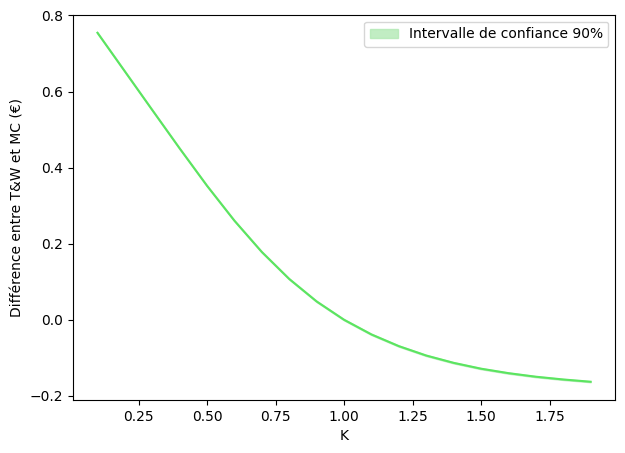

In [92]:
plt.plot(K_range, approx_vec-tnw_approx, c=GREEN)
plt.fill_between(K_range, lower-tnw_approx, upper-tnw_approx, color=FILL_GREEN, label="Intervalle de confiance 90%")

plt.xlabel("K")
plt.ylabel("Différence entre T&W et MC (€)")
plt.legend()
plt.savefig("figures/diff_tnw_over_K.png", dpi=IMG_DPI)
plt.show()

### Ploting against $\sigma$

In [93]:
def approx_calc_sig(sig, price_paths):
    # Control variable monte-carlo
    r_e, sig_e = ctrl_coeffs(r, sig, num_subdivs)
    control_mean = call_eur_bs(r_e, sig_e, T, S0, K)
    asian_mc_samples = np.maximum(price_paths.mean(axis=1) - K, 0)
    control_samples = np.maximum(np.exp( np.log(price_paths)[:,1:].mean(axis=1) ) - K, 0)
    asian_ctrl_mc_samples = np.exp(-r*T)*(asian_mc_samples - control_samples) + control_mean

    approx = asian_ctrl_mc_samples.mean()
    std_dev = asian_ctrl_mc_samples.std(ddof=1) / np.sqrt(len(asian_ctrl_mc_samples))
    return approx, std_dev

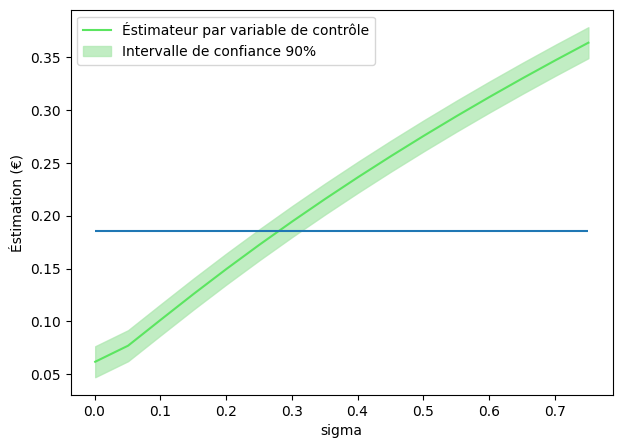

In [94]:
chosen_num_paths = 100 # To be calculated with a real criterion
critical_value = 1.645

price_paths = price_paths_bs(r, sig, T, S0, num_subdivs, chosen_num_paths)
sig_range = np.arange(0.001, 0.8, 0.05)
approx_vec = np.zeros(sig_range.shape)
std_vec = np.zeros(sig_range.shape)
for i in range(len(sig_range)):
	approx, std_dev = approx_calc_sig(sig_range[i], price_paths)
	approx_vec[i] = approx
	std_vec[i] = std_dev

tnw_approx = call_asian_bs_tnw_dis(r, sig, T, S0, K, num_subdivs)
lower = approx_vec - critical_value * std_vec
upper = approx_vec + critical_value * std_vec
plt.plot(sig_range, approx_vec, c=GREEN, label="Éstimateur par variable de contrôle")
plt.fill_between(sig_range, lower, upper, color=FILL_GREEN, label="Intervalle de confiance 90%")

plt.hlines(tnw_approx, xmin=sig_range.min(), xmax=sig_range.max())
plt.xlabel("sigma")
plt.ylabel("Éstimation (€)")
plt.legend()
plt.savefig("figures/value_vs_sig.png", dpi=IMG_DPI)
plt.show()

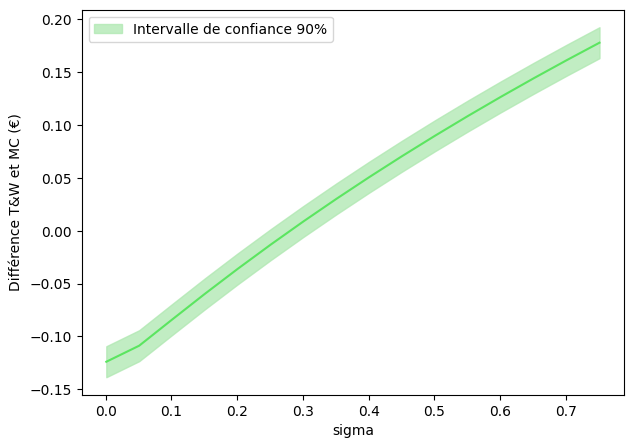

In [95]:
plt.plot(sig_range, approx_vec-tnw_approx, c=GREEN)
plt.fill_between(sig_range, lower-tnw_approx, upper-tnw_approx, color=FILL_GREEN, label="Intervalle de confiance 90%")

plt.xlabel("sigma")
plt.ylabel("Différence T&W et MC (€)")
plt.legend()
plt.savefig("figures/value_vs_sig.png", dpi=IMG_DPI)
plt.show()

### Ploting T&W for multiple Dt

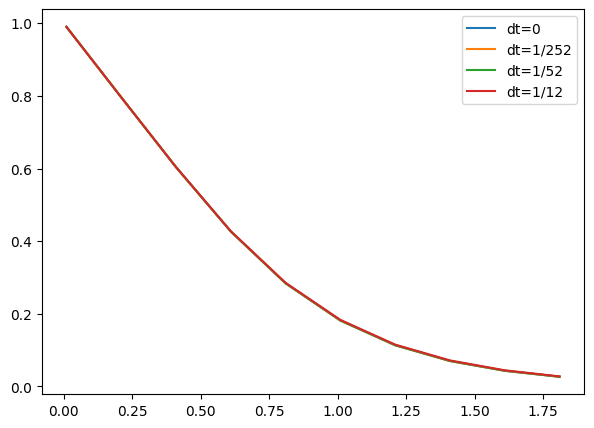

In [96]:
K_range = np.arange(0.01, 2.0, 0.2)
call_tnw_dis = np.vectorize(call_asian_bs_tnw_dis)
call_tnw_con = np.vectorize(call_asian_bs_tnw_con)
subdiv_values = [252, 52, 12]

plt.plot(K_range, call_tnw_con(r, sig, T, S0, K_range), label="dt=0")
for subdivs in subdiv_values:
	num_subdivs = T*subdivs
	plt.plot(K_range, call_tnw_dis(r, sig, T, S0, K_range, num_subdivs), label=f"dt=1/{subdivs}")
plt.legend()
plt.savefig("figures/tnw_dts.png", dpi=IMG_DPI)
plt.show()

### M-C VS T&W for multiple Dt

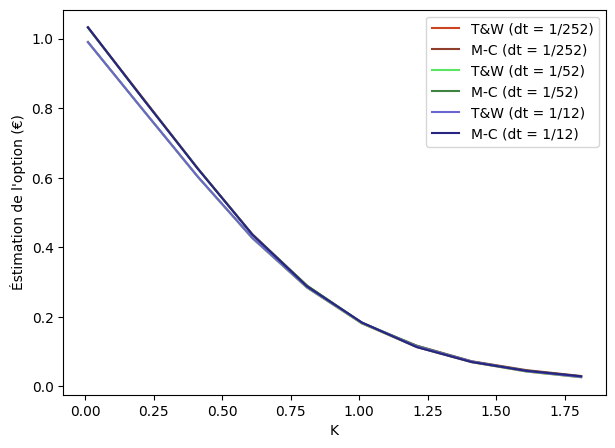

In [97]:
K_range = np.arange(0.01, 2.0, 0.2)
call_ctrl = np.vectorize(call_asian_bs_mc_ctrl)
subdiv_vals = [252, 52, 12]
tnw_cols = [RED, GREEN, BLUE]
mc_cols = [DARK_RED, DARK_GREEN, DARK_BLUE]

for i in range(len(subdiv_values)):
    subdiv = subdiv_vals[i]

    num_subdivs = T*subdiv
    tnw_vals = call_tnw_dis(r, sig, T, S0, K_range, num_subdivs)
    mc_vals = call_ctrl(r, sig, T, S0, K_range, num_subdivs, num_paths)[0]
    plt.plot(K_range, tnw_vals, label=f"T&W (dt = 1/{subdiv})", c=tnw_cols[i])
    plt.plot(K_range, mc_vals, label=f"M-C (dt = 1/{subdiv})", c=mc_cols[i])

plt.xlabel("K")
plt.ylabel("Éstimation de l'option (€)")
plt.legend()
plt.savefig("figures/mc_vs_tnw_dts.png", dpi=IMG_DPI)
plt.show()

## Compute time

In [98]:
import timeit

# a number of path that takes long enough on my computer to do stats
large_num_paths = 10000
subdiv_vals = [12, 52, 252]
subdiv_labels = [f"Dt=1/{d}" for d in subdiv_vals]
tnw_cols = [RED, GREEN, BLUE]
mc_cols = [DARK_RED, DARK_GREEN, DARK_BLUE]
x = np.arange(len(subdiv_labels))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

# call_asian_bs_mc_ctrl(r,sig,T,S0,K,num_paths, large_num_paths)
tnw_times = np.zeros(len(subdiv_vals))
mc_times = np.zeros(len(subdiv_vals))

for i in range(len(subdiv_vals)):
    num_subdivs = T * subdiv_vals[i]
    tnw_times[i] = 1000 * timeit.timeit(lambda: call_asian_bs_tnw_dis(r,sig,T,S0,K, num_subdivs), number=1)
    mc_times[i] = 1000 * timeit.timeit(lambda: call_asian_bs_mc_ctrl(r,sig,T,S0,K, num_subdivs, large_num_paths), number=1)

/tmp/ipykernel_16079/3885770287.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ymax)


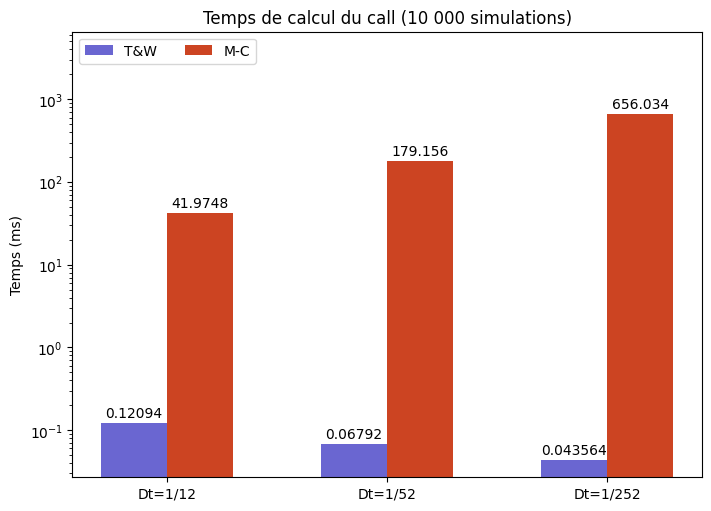

In [99]:
fig, ax = plt.subplots(layout='constrained')

# Ploting T&W
offset = width*0.5
rects = ax.bar(x + offset, tnw_times, width, label="T&W", log=True, color=BLUE)
ax.bar_label(rects, padding=2)

# Ploting M-C
offset = width*1.5
rects = ax.bar(x + offset, mc_times, width, label="M-C", log=True, color=RED)
ax.bar_label(rects, padding=2)

ax.set_ylabel("Temps (ms)")
ax.set_title("Temps de calcul du call (10 000 simulations)")
ax.set_xticks(x + width, subdiv_labels)
ax.legend(loc="upper left", ncols=2)
ymax = np.max(mc_times) * 10
ax.set_ylim(0, ymax)
plt.savefig("figures/times.png", dpi=IMG_DPI)
plt.show()